# Feature Selection

**PROCESS**
For our feature selection model we use the following methods:
1. Lasso Regularization
2. Tree-based Classification (Random Tree Classifier with Gradient Boosting)
3. Step Forward Selection (SFS)
4. Exhasutive Forwars Selection (EFS)l

Before starting on our feature selection model, we also use the sklearn.feature_selection_SelectKBest model as a baseline. We evaluate the performance of this libarary on the dataset with k= 20, since we know that there are 20 combinational useful features. The accuracy of the model to predict the final set of feature set is noted with the help of our benchmark model ie. Decision Tree Classifier.



**RESULTS**
We combine the two methods with the highest accuracy (Tree-based Classification and Step Forward Selection) to carry out a voting of features. The features that are voted by both the methods are moved forward for further processing. As a part of the final task, we carry out an Exhasutive forward selection (Greedy search) that checks each combination of features to find out the highest accuracy that can be achieved. From this, we finally get our 5 true features.

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [2]:
from scipy import stats
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE, chi2, f_regression

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

### Load Data

In [3]:
'''Load and quick check the data'''
df= pd.read_csv("medilon.csv")
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V492,V493,V494,V495,V496,V497,V498,V499,V500,Class
0,485,477,537,479,452,471,491,476,475,473,...,481,477,485,511,485,481,479,475,496,2
1,483,458,460,487,587,475,526,479,485,469,...,478,487,338,513,486,483,492,510,517,2
2,487,542,499,468,448,471,442,478,480,477,...,481,492,650,506,501,480,489,499,498,2
3,480,491,510,485,495,472,417,474,502,476,...,480,474,572,454,469,475,482,494,461,1
4,484,502,528,489,466,481,402,478,487,468,...,479,452,435,486,508,481,504,495,511,1


In [4]:
X = df.drop(['Class'], axis = 1)
y = df['Class']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1. SelectKBest
Firstly, we use the sklearn's SelectKBest for selecting our prominent features.

In [6]:
skb = SelectKBest()

In [7]:
def find_KBest(data):
    '''
    Find the 20 best features from a set of data. Data input should come without a target column.
    '''
    for col in data.columns:
        
        X = data.drop([col], axis = 1)
        y = data[col]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
        
        fit = SelectKBest(score_func= f_regression, k=20).fit(X_train, y_train)
    
        skb_feats = list(np.where(fit.get_support())[0])
        
    return skb_feats

In [8]:
skb_feats = find_KBest(X)

In [9]:
print('The number of features selected are:', len(skb_feats))
print('The selected features are:', skb_feats)

The number of features selected are: 20
The selected features are: [12, 34, 76, 95, 119, 141, 183, 293, 307, 350, 351, 361, 364, 383, 389, 397, 424, 430, 451, 488]


In [10]:
X_train_kbest = X_train.iloc[:, skb_feats]
X_test_kbest = X_test.iloc[:, skb_feats]
X_test_kbest.head()

,V13,V35,V77,V96,V120,V142,V184,V294,V308,V351,V352,V362,V365,V384,V390,V398,V425,V431,V452,V489
1593,494,471,482,486,502,552,468,480,483,473,447,501,479,486,464,449,489,494,466,465
196,497,482,477,447,497,476,493,477,472,481,560,491,483,481,511,442,477,454,482,480
239,526,496,476,483,496,507,421,479,482,488,470,475,488,469,569,539,483,466,488,502
2126,453,453,490,525,482,522,466,482,488,475,503,480,480,506,437,511,503,461,473,500
1587,444,488,476,493,451,449,474,486,463,483,484,475,486,499,523,483,508,482,484,507


In [11]:
scaler = StandardScaler().fit(X_train_kbest)
X_train_kbest = scaler.transform(X_train_kbest)

scaler = StandardScaler().fit(X_test_kbest)
X_test_kbest = scaler.transform(X_test_kbest)

clfr = DecisionTreeClassifier(random_state=42)
clfr.fit(X_train_kbest, y_train)

train_score = clfr.score(X_train_kbest, y_train)
test_score = clfr.score(X_test_kbest, y_test)
pred = clfr.predict(X_test_kbest)
print('The testing accuracy for the SelectKBest Model is, ', test_score)

The testing accuracy for the SelectKBest Model is,  0.49230769230769234


- The problem with SelectKBest is we need to guess the value of "k" to get the number of relevant features right. To overcome this limitation, we need a more sophisticated approach to filter out the noisy data.

- Recursive Feature Elimination models the data based on the given estimator to pick out the best features, and order them according to the highest accuracy.

- We can control the regularization using regression based algorithm with penalty terms. For this method, we use the Lasso or the L1 regularization since it sets the value of undesired features to zero and removes them from the dataset.

- Another approach would be to use a non-linear estimator such as a Random Forest Classifier, since it can look past the noise present in the dataset. It generates multiple hundred trees that contain some degree of randomization which helps to escape the correlations between similar trees. Random forest overcomes such bias that might be present when using only a single estimator like a Decision Tree Classifier.

## 2. Stepwise Regression (Lasso -L1)
       

In [12]:
'''Hyperparameter tuning to find optimal C'''
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel

cs_ = []
scores_ = []
for c in np.arange(0.0003, 0.0005, 0.00001):
    '''We use a Logistic Regression model with the penalty set to Lasso (L1) regularization.
    Then we use selectFromModel from sklearn, which will select the features whose coefficients are non-zero.'''
    sel_ = SelectFromModel(estimator=LogisticRegression( C=c , penalty='l1'))
    sel_.fit(X_train, y_train)
    selected_feat = X_train.columns[(sel_.get_support())] #Make a list of with selected features
    print(c)
    print('Selected features: {}'.format(len(selected_feat)))
    X_train_selected = sel_.transform(X_train)
    X_test_selected = sel_.transform(X_test)
    clfr = DecisionTreeClassifier(random_state=42)
    clfr.fit(X_train_selected, y_train)
    test_score = clfr.score(X_test_selected, y_test)
    cs_.append(c)
    scores_.append(test_score)

c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0003
Selected features: 5


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.00031
Selected features: 6


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.00032
Selected features: 6


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.00033000000000000005
Selected features: 6


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0003400000000000001
Selected features: 7


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0003500000000000001
Selected features: 7


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.00036000000000000013
Selected features: 8


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.00037000000000000016
Selected features: 8


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0003800000000000002
Selected features: 9


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0003900000000000002
Selected features: 9


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.00040000000000000024
Selected features: 9


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.00041000000000000026
Selected features: 9


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0004200000000000003
Selected features: 10


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0004300000000000003
Selected features: 10


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.00044000000000000034
Selected features: 12


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.00045000000000000037
Selected features: 12


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0004600000000000004
Selected features: 12


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0004700000000000004
Selected features: 13


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.00048000000000000045
Selected features: 14


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0004900000000000004
Selected features: 15


c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0005000000000000004
Selected features: 15


In [13]:
import operator
index, value = max(enumerate(scores_), key=operator.itemgetter(1))
index, value
print("The optimal value of parameter C is", cs_[index], scores_[index])
print("Highest accuracy achieved is,", scores_[index])

The optimal value of parameter C is 0.00036000000000000013 0.7942307692307692
Highest accuracy achieved is, 0.7942307692307692


In [14]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel

'''We use a Logistic Regression model with the penalty set to Lasso (L1) regularization.
Then we use selectFromModel from sklearn, which will select the features whose coefficients are non-zero.'''
sel_ = SelectFromModel(estimator=LogisticRegression(C=0.00036, penalty='l1')) #0.00036 0.000659
sel_.fit(X_train, y_train)

c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=0.00036, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='warn',
                                             n_jobs=None, penalty='l1',
                                             random_state=None, solver='warn',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [15]:
'''We see which features were kept (True) and which were discarded (False) in the resulting array'''
sel_.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [16]:
selected_feat = X_train.columns[(sel_.get_support())] #Make a list of with selected features
print('Total features: {}'.format((X_train.shape[1])))
print('Selected features: {}'.format(len(selected_feat)))
print('Features with coefficients shrunk to 0: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))
print(selected_feat) 

Total features: 500
Selected features: 8
Features with coefficients shrunk to 0: 492
Index(['V222', 'V286', 'V337', 'V339', 'V379', 'V443', 'V476', 'V494'], dtype='object')


In [17]:
def get_index(Selected_features):
    Selected_indexes = []
    for feat in Selected_features:
        val = feat[1:]
        index = int(val) -1
        Selected_indexes.append(index)
    return Selected_indexes

In [18]:
Selected_features = list(selected_feat) #List the selected features
Selected_indexes_Lasso = get_index(Selected_features) ##[28, 48, 336, 338, 493]
Selected_indexes_Lasso

[221, 285, 336, 338, 378, 442, 475, 493]

In [19]:
'''Keep only the selected features in the dataset'''
X_train_selected = sel_.transform(X_train)
X_test_selected = sel_.transform(X_test)
X_train_selected.shape, X_test_selected.shape #Check if features removed successfully

((2080, 8), (520, 8))

In [20]:
'''Use our benchmark model ie. DecisionTreeClassifier for prediction'''
clfr = DecisionTreeClassifier(random_state=42)
clfr.fit(X_train_selected, y_train)
train_score = clfr.score(X_train_selected, y_train)
test_score = clfr.score(X_test_selected, y_test)
pred = clfr.predict(X_test_selected)

In [21]:
print('The accuracy from Lasso regression method is', test_score) #Print accuracy on the test set

The accuracy from Lasso regression method is 0.7942307692307692


In [22]:
'''Conclusion'''
print('Hence, with Lasso regression we get accuracy (Decision Tree):', test_score)
print('The selected features are:', Selected_indexes_Lasso)

Hence, with Lasso regression we get accuracy (Decision Tree): 0.7942307692307692
The selected features are: [221, 285, 336, 338, 378, 442, 475, 493]


## 3. Tree-based Selection

In [23]:
'''Load data'''
X = df.drop(['Class'], axis = 1)
y = df['Class']

scaler= StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X = pd.DataFrame(X)

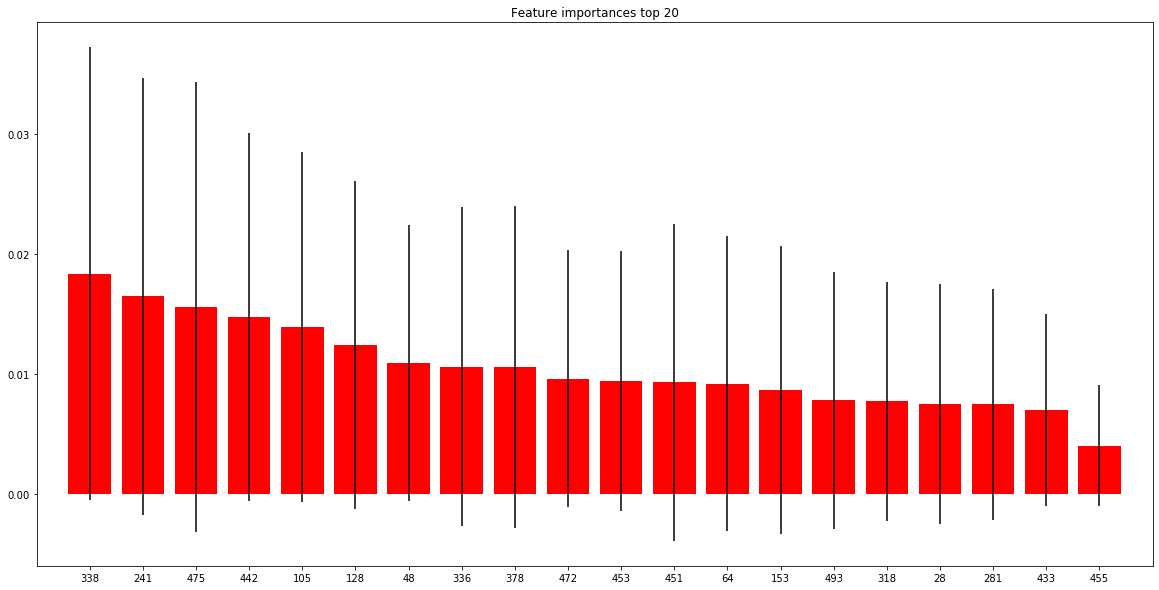

In [24]:
'''Impurity-based feature importance of RandomForestCClassifier'''
rfc = RandomForestClassifier(n_estimators = 100, random_state = 0, n_jobs = -1)
 
feat_labels = X.columns.values

rfc.fit(X, y)

importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
                 axis=0)
zipped = zip(feat_labels, importances)

sorted_list = sorted(zipped, key=lambda x: x[1])
gini_values = sorted_list[::-1]

a_rfc = gini_values[:20]

top_n = 20
indices = indices[0:top_n]
plt.figure(figsize = (20,10))
plt.title("Feature importances top %d" % top_n)
plt.bar(range(top_n), importances[indices], 
        color="r", yerr=std[indices], align="center")
plt.xticks(range(top_n), indices)
plt.xlim([-1,top_n])
plt.show()

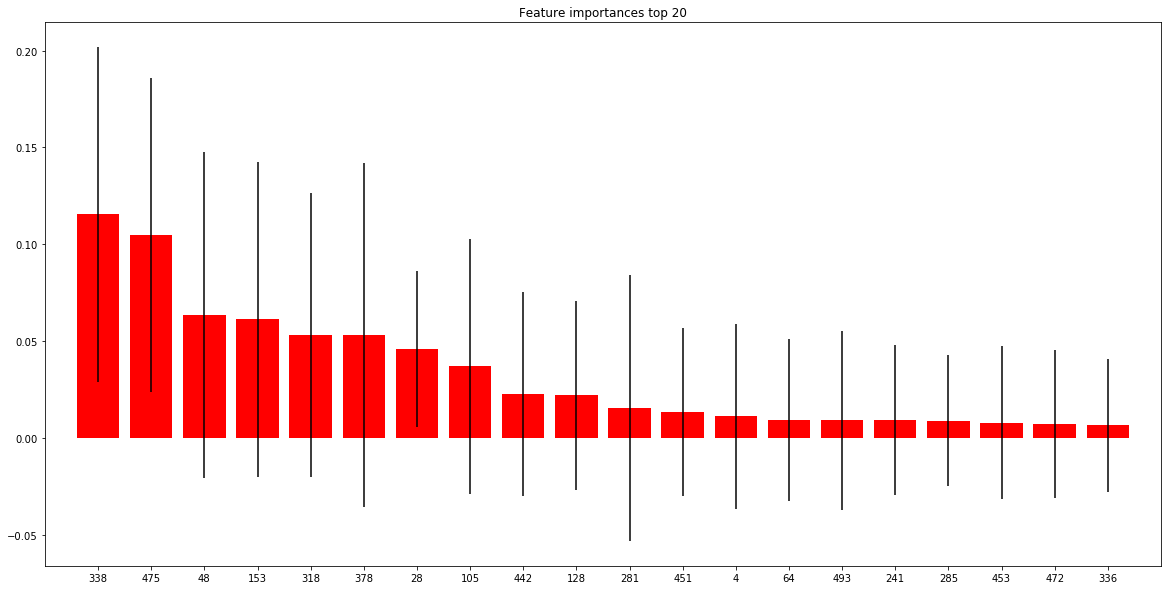

In [25]:
'''Features selected on the basis of their learning capability to predict the target'''
gbc = GradientBoostingClassifier(n_estimators=100, random_state = 0)
 
feat_labels = X.columns.values

gbc.fit(X, y)

importances = gbc.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree[0].feature_importances_ for tree in gbc.estimators_],
                 axis=0)
zipped = zip(feat_labels, importances)

sorted_list = sorted(zipped, key=lambda x: x[1])
gini_values = sorted_list[::-1]

a_gbc = gini_values[:20]

top_n = 20
indices = indices[0:top_n]
plt.figure(figsize = (20,10))
plt.title("Feature importances top %d" % top_n)
plt.bar(range(top_n), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(top_n), indices)
plt.xlim([-1,top_n])
plt.show()

In [26]:
'''Adding the values of the impurity based feature importance and its capability to learn'''
index_of_added = []
added_importance = []
for i , j in a_rfc:
    for k, l in a_gbc:
        if i == k:
            index_of_added.append(i)
            added_importance.append(j+l)
zipped = zip(index_of_added, added_importance)
# for feature in zip(index_of_added, added_importance):
#     print(feature)
    
sorted_added_list = sorted(zipped, key=lambda x: x[1])[::-1]
sorted_added_list #(Feature, Leaning_capability); sorted by Learning capability

[(338, 0.13382703595381673),
 (475, 0.12035663976046118),
 (48, 0.07435055896717277),
 (153, 0.06997644678731912),
 (378, 0.06369234686883314),
 (318, 0.060880832344004154),
 (28, 0.05359550539416976),
 (105, 0.0508352272728366),
 (442, 0.03738264032370535),
 (128, 0.034441704351852745),
 (241, 0.025601017396147605),
 (281, 0.022888182467441866),
 (451, 0.02283670667037866),
 (64, 0.0184644387914576),
 (453, 0.01724383648491406),
 (336, 0.017069051999870417),
 (493, 0.016938738290663963),
 (472, 0.01688432814465833)]

In [27]:
'''Get only features index from above list'''
Selected_indexes_Tree=[]
for i in range(len(sorted_added_list)):
    Selected_indexes_Tree.append(sorted_added_list[i][0])
Selected_indexes_Tree = sorted(Selected_indexes_Tree)
Selected_indexes_Tree

[28,
 48,
 64,
 105,
 128,
 153,
 241,
 281,
 318,
 336,
 338,
 378,
 442,
 451,
 453,
 472,
 475,
 493]

In [28]:
'''Acurracy obtained by taking top 10 features'''
chosendf = X.iloc[:, Selected_indexes_Tree[:10]]

Rf_train, Rf_test, y_train, y_test = train_test_split(chosendf, y, test_size=0.2, random_state=42)
rfc = DecisionTreeClassifier(random_state = 42)
rfc.fit(Rf_train, y_train)
rfc_predict = rfc.predict(Rf_test)

print("Accuracy with top 10 features: ", accuracy_score(y_test, rfc_predict))

Accuracy with top 10 features:  0.801923076923077


## 4.  Step Forward Selection (SFS)

In [29]:
'''Step Foward Selection with DecisionTree Classification'''

from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs = SFS(DecisionTreeClassifier(random_state=42),
         k_features = 20,
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = 4,
          n_jobs= -1
         ).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.9s finished

[2019-12-09 14:49:54] Features: 1/20 -- score: 0.5687704665498592[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 484 out of 499 | elapsed:    6.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 499 out of 499 | elapsed:    6.3s finished

[2019-12-09 14:50:01] Features: 2/20 -- score: 0.5817632746138399[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 498 out of 498 | elapsed:    6.3s finished

[2019-12-09 14:50:08] Features: 3/2

In [30]:
# '''Selected features and indexes'''
print('Accuracy from SFS', sfs.k_score_)
Selected_features_SFS = sfs.k_feature_names_
Selected_indexes_SFS = list(sfs.k_feature_idx_)

Accuracy from SFS 0.8173128982896216


In [31]:
'''Comparing the list of outputs from Lasso and Tree'''
print(Selected_indexes_Lasso) #Using lasso
print(Selected_indexes_Tree) #Using Tree
print(Selected_indexes_SFS) #Using SFS

[221, 285, 336, 338, 378, 442, 475, 493]
[28, 48, 64, 105, 128, 153, 241, 281, 318, 336, 338, 378, 442, 451, 453, 472, 475, 493]
[48, 100, 128, 191, 195, 198, 279, 281, 295, 317, 318, 338, 340, 378, 404, 423, 435, 451, 472, 475]


In [32]:
'''Find commond indexes from Lasso, Tree and SFS'''
# Common_indexes = []
# for i in Selected_indexes_Tree:
#     for j in Selected_indexes_Lasso:
#         for k in Selected_indexes_SFS:
#             if i == j == k:
#                 Common_indexes.append(i)
# Common_indexes

'''Find commond indexes from Tree and SFS'''
Common_indexes = []
for i in Selected_indexes_Tree:
    for j in Selected_indexes_SFS:
        if i == j:
            Common_indexes.append(i)
Common_indexes 

[48, 128, 281, 318, 338, 378, 451, 472, 475]

In [33]:
'''Create a dataframe with just the above features and compute accuracy'''
chosendf = X.iloc[:, Common_indexes]
Rf_train, Rf_test, y_train, y_test = train_test_split(chosendf, y, test_size=0.2, random_state=42)
rfc = DecisionTreeClassifier(random_state = 42)
rfc.fit(Rf_train, y_train)
rfc_predict = rfc.predict(Rf_test)

print("Accuracy: ", accuracy_score(y_test, rfc_predict))

Accuracy:  0.8269230769230769


In [34]:
'''Fresh re-load of dataset'''
X = df.drop(['Class'], axis = 1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_ = X_train.iloc[:, Common_indexes]
X_test_ = X_test.iloc[:, Common_indexes]
X_train_

,V49,V129,V282,V319,V339,V379,V452,V473,V476
582,443,500,481,503,339,443,480,480,641
48,416,497,469,551,340,392,489,469,570
1772,526,475,567,446,479,563,470,473,431
964,442,476,454,434,559,442,467,536,498
2213,419,476,532,443,480,416,468,531,446
...,...,...,...,...,...,...,...,...,...
1638,463,467,493,497,574,467,480,475,421
1095,517,450,444,410,829,535,469,555,282
1130,486,485,528,456,488,500,471,530,407
1294,513,482,516,521,419,536,486,412,547


In [35]:
'''Pick 5 most useful features using Exhaustive Feature Selection'''
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
efs = EFS(DecisionTreeClassifier(random_state=42),
         min_features= 5,
          max_features= 5,
          scoring='accuracy',
          cv = 20,
          n_jobs=-1
         ).fit(X_train_, y_train)

Features: 126/126

In [37]:
print('The highest accuracy acheived by EFS is', efs.best_score_)  #Accuracy score

The highest accuracy acheived by EFS is 0.8270289661794517


In [38]:
Selected_features_Final = list(efs.best_feature_names_)
print('The final selected features are,',Selected_features_Final)

The final selected features are, ['V129', 'V282', 'V319', 'V379', 'V476']


In [39]:
Selected_indexes_Final = get_index(Selected_features_Final)
Selected_indexes_Final

[128, 281, 318, 378, 475]

### Keep only 5 final features in dataset

In [40]:
'''Load data'''
X = df.drop(['Class'], axis = 1)
y = df['Class']

scaler= StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X = pd.DataFrame(X)

print(X.shape)

(2600, 500)


In [41]:
chosendf = X.iloc[:, Common_indexes]

print("Final dimensions of inputdataset is: ", chosendf.shape)

Rf_train, Rf_test, y_train, y_test = train_test_split(chosendf, y, test_size=0.2, random_state=42)
rfc = DecisionTreeClassifier(random_state = 42)
rfc.fit(Rf_train, y_train)
rfc_predict = rfc.predict(Rf_test)

print("Accuracy: ", accuracy_score(y_test, rfc_predict))

Final dimensions of inputdataset is:  (2600, 9)
Accuracy:  0.8269230769230769


In [ ]:
print('Performance measures for test set:')
print('Accuracy:', accuracy_scores(y_test, rfc_predict))
print('F1 Score:',f1_score(y_test, rfc_predict))
print('Precision Score:',precision_score(y_test, rfc_predict))
print('Recall Score:', recall_score(y_test, rfc_predict))
print('Confusion Matrix:\n', confusion_matrix(y_test, rfc_predict))
print()